In [1]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
from scipy.stats import lognorm,norm
from scipy import stats
import pandas as pd

rez=100

In [5]:
#whole AB model
def Ab_model(t,A0,phi,r,s,hill,IC50):
    Ab_t = A0*(np.exp(-r*t)+phi*np.exp(-s*t))
    if A0>0:
        E_t = 1/(1+(Ab_t/IC50)**-hill)
    else:
        E_t=0
    return Ab_t,E_t

#updating the rates of events
num_rates=21; num_states=7; rl=np.zeros(num_rates); T=np.zeros([num_rates,num_states])

def update_rates(X,ti,A0,phi,r,s,hill,IC50,psi):
        
    Ab_t,E_t = Ab_model(ti%56,A0,phi,r,s,hill,IC50)    #refreshes every 8 weeks

    Bt=Bt0*(1-E_t) #ab dependent infectivity
    
    S=X[0]; AU=X[1]; AP=X[2]; LU=X[3]; LP=X[4]; E=X[5]; V=X[6];    
    
    #kp=0.1; pr=np.random.gamma(kp,p)
    pr=np.random.poisson(p)
    
    rl[0] = aS;                     T[0][:]=[ 1,0,0,0,0,0,0];  #constant production 
    rl[1] = dS*S;                   T[1][:]=[-1,0,0,0,0,0,0]  #density dependent susceptible death
    rl[2] = (1-tau)*(1-lam)*Bt*S*V; T[2][:]=[-1,1,0,0,0,0,-1] #unproductive active infection
    rl[3] = tau*(1-lam)*Bt*S*V;     T[3][:]=[-1,0,1,0,0,0,-1] #productive active infection
    rl[4] = (1-tau)*lam*Bt*S*V;     T[4][:]=[-1,0,0,1,0,0,-1] #unproductive latent infection
    rl[5] = tau*lam*Bt*S*V;         T[5][:]=[-1,0,0,0,1,0,-1] #productive latent infection
    rl[6] = dA*AU;                  T[6][:]=[0,-1,0,0,0,0,0]  #unproductive active death
    rl[7] = dA*AP;                  T[7][:]=[0,0,-1,0,0,0,pr]  #productive active death and virus burst
    rl[8] = dL*LU;                  T[8][:]=[0,0,0,-1,0,0,0]  #unproductive latent death
    rl[9] = dL*LP;                  T[9][:]=[0,0,0,0,-1,0,0]  #productive latent death
    rl[10] = aL*LU;                 T[10][:]=[0,0,0,1,0,0,0]  #unproductive latent proliferation
    rl[11] = aL*LP;                 T[11][:]=[0,0,0,0,1,0,0]  #productive latent proliferation
    rl[12] = xi*LU;                 T[12][:]=[0,1,0,-1,0,0,0]  #unproductive latent activation
    rl[13] = xi*LP;                 T[13][:]=[0,0,1,0,-1,0,0]  #productive latent activation
    rl[14] = k*E*AU;                T[14][:]=[0,-1,0,0,0,0,0]  #unproductive active immune removal
    rl[15] = k*E*AP;                T[15][:]=[0,0,-1,0,0,0,0]  #productive active immune removal
    rl[16] = w*E*(AP+AU)/(E+E50);   T[16][:]=[0,0,0,0,0,1,0]  #immune cell recruitment
    rl[17] = aE;                    T[17][:]=[0,0,0,0,0,1,0]  #immune cell birth
    rl[18] = dE*E;                  T[18][:]=[0,0,0,0,0,-1,0]  #immune cell clearance
    rl[19] = g*V;                   T[19][:]=[0,0,0,0,0,0,-1]  #innate viral clearance
    #rl[20] = psi*Ab_t*V;            T[20][:]=[0,0,0,0,0,0,-1]  #bnAb viral clearance
    
    return rl,T

#function that solves stochastically using tau-leap method
def bnabs_tauleap(t,fp_time,A0,phi,r,s,hill,IC50,psi):

    dt=t[1]; x=np.array([aS/dS,0,0,0,0,aE/dE,0]); y=[] #initialize
    fp_flag='no'
    for ti in t:
        
        y.append(x) #the list of states

        rate_list,T = update_rates(x,ti,A0,phi,r,s,hill,IC50,psi) #make new rate vector
        
        events = np.random.poisson(rate_list*dt) #calculate events
        
        events_list.append(events)
        
        dx = np.sum(np.matrix.transpose(T)*events,1) #calculate change in state
        
        x=x+dx #update state variable
        
        if ti>fp_time and fp_flag=='no':
            x[2] = x[2] + 1
            fp_flag=='yes'
 
        x[x<1]=0 #make sure no negative numbers or fractions
                
    return np.array(y)

In [6]:
# parameters for viral dynamics model
vol = 1e6       # volume of blood [uL]
aS  = 125*vol;   #constant growth rate of susceptibles [cells/uL/day]
dS  = 0.47;   #susceptible death rate [1/day] 
Bt0 = 1e-4/vol  # infection rate of T-cells [uL/cells-day]/[uL]
dA  = 1.0       # active death rate [1/day]
p   = 2e4       # burst rate of virus from cells [virions/cell]
g   = 23        # virus clearance rate [1/day]
tau = 0.05      # productive infection probability []
lam = 1e-4      # latency probability []
thL = 5.2e-4    # latent clearance rate [1/day]
aL  = 0.015;    # latent proliferation rate [1/day] (Tcm)
xi  = 1e-5;     # latent activation rate [1/day]
dL  = aL-thL-xi # latent death rate
k   = 0.3/vol;  #immune cell killing rate [uL/cell-day]/[uL]
w   = 1.6;     #immune cell multiplier [1/day]
aE  = 1e-4*vol;   #initial E cell concentration [cells/uL]*[uL]
dE  = 0.002;  #immune death rate [1/day]
E50 = 260*vol;   #50 pct max E cell concentration [cells/uL]*[uL]
tau = 0.05   #productively infected probability
p   = 5e4    #leak+burst viral production rate [virions/cell]
g   = 23      #viral clearance [1/day]

#equilibriu solutions
#l=1-(1+xi/thL)*tau #latency factor
#Xeq=np.array([g*dA/Bt0/p/l,tau/thL*(g*dS*dA/Bt0/p/l-aS),aS*l/dA-g*dS/Bt0/p,aS*p*l/g/dA-dS/Bt0])

R0=aS*Bt0*tau*(1-lam)*p/g/dS/dA; print(R0) # basic reproductive number

#PK parameters
A0,phi,r,s = 0, 0, 0.348, 0.0538 #low 30 or high 10 dose range

#PD parameters
IC50=20 # IC50 [ug/uL]
hill=1  # hill coefficient []
psi=3

x0=np.array([aS/dS,0,0,0,0,aE/dE,1e-3]) #initial model conditions

tt=np.linspace(0,7*8,1e3)



2.8905527289546726


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide


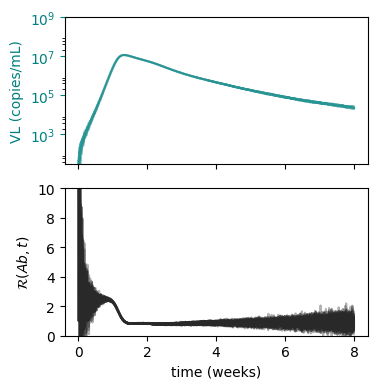

In [8]:
#do simulations

A0,phi,r,s = 1,0,0.348,0.0538 #low 30 or high 10 dose range
#A0,phi,r,s = 225,35,0.348,0.0538 #low 30 or high 10 dose range
IC50=2
hill=1
psi=0.01

num_sims=5; 
tt=np.linspace(0,8*7,1e4)

fp_time=0

Ab_t,E_t = Ab_model(tt%56,A0,phi,r,s,hill,IC50)    #refreshes every 8 weeks

col1='teal'
col2='black'

fig, ax = plt.subplots(2,1,figsize=(4,4),dpi=rez,sharex=True)
#figE, axE = plt.subplots(3,7,figsize=(6,12),dpi=rez,sharex=True)
ax1=ax[0]
ax2=ax[1]
rr=1
for i in range(num_sims):
    events_list=[]
    tlp_sol = bnabs_tauleap(tt,0,A0,phi,r,s,hill,IC50,psi)
    #axE[int(i/7)][i%7].plot(tt,np.array(E_list)[:,i])
    dIdt=np.diff(tlp_sol[:,2])
    I=tlp_sol[1:,2]
    dt=tt[1]
    Rt=1+dIdt/(I*dt*dA)
    ax1.semilogy(tt[0::rr]/7,tlp_sol[0::rr,6]/vol*1e3+0.1,alpha=0.3,color=col1)
    ax2.plot(tt[1:]/7,Rt,color=col2,alpha=0.3)

ax1.set_ylabel('VL (copies/mL)',color=col1)
ax2.set_xlabel('time (weeks)')
ax1.tick_params('y', colors=col1)
ax1.set_ylim([30,1e9])
ax2.set_ylabel('$\mathcal{R}(Ab,t)$',color=col2)
ax2.tick_params('y', colors=col2)
ax2.set_ylim([0,10])

fig.tight_layout()

fig.savefig('figures/sto_virus.pdf')  # No warning now


In [ ]:
#2 dose simulation

t=np.linspace(0,16*7,1e4) #2 dose curve

#best case scenario for treatment reasons
ic80=10**min(log80); Abc=300 

prop_inhib=response80(dose=Ab_conc(Abc,Abc/4,r1,r2,(t%56)/7),IC80=ic80)
Rt=(1-prop_inhib)*R0 #R0 over time

num_sims=10; 
trial_inds=np.linspace(0,len(t)-100,num_sims)

plt.figure(figsize=(6,4),dpi=600)
for i in range(num_sims):
    tlp_sol = bnabs_tauleap(t,Ab0=Abc,inc_time=t[trial_inds[i]],IC80=ic80,X0=x0)
    plt.subplot(211)
    plt.plot(t/7,Rt,'k')
    plt.ylim([0,10])
    plt.ylabel(r'$\mathcal{R}(Ab,t)$',fontsize=12)
    plt.subplot(212)
    plt.semilogy(t/7,tlp_sol[:,3]/5e3,alpha=0.6)
    plt.ylabel('Viral load (copies/mL)')
    plt.ylim([1,1e9])
plt.xlabel('time (weeks)')

plt.tight_layout()
plt.gcf().savefig('10_exposures_best.pdf')  # No warning now


In [ ]:

#worst case scenario for treatment reasons
ic80=10**max(log80); Abc=60 
prop_inhib=response80(dose=Ab_conc(Abc,Abc/4,r1,r2,(t%56)/7),IC80=ic80)
Rt=(1-prop_inhib)*R0 #R0 over time

plt.figure(figsize=(6,4),dpi=600)
for i in range(num_sims):
    tlp_sol = bnabs_tauleap(t,Ab0=Abc,inc_time=t[trial_inds[i]],IC80=ic80,X0=x0)
    plt.subplot(211)
    plt.plot(t/7,Rt,'k')
    plt.ylim([0,10])
    plt.ylabel(r'$\mathcal{R}(Ab,t)$',fontsize=12)
    plt.subplot(212)
    plt.semilogy(t/7,tlp_sol[:,3]/5e3,alpha=0.6)
    plt.ylabel('Viral load (copies/mL)')
    plt.ylim([1,1e9])
plt.xlabel('time (weeks)')

plt.tight_layout()
plt.gcf().savefig('10_exposures_worst.pdf')  # No warning now



In [ ]:
#more realistic scenario
ic80=10**np.median(log80); Abc=100 
prop_inhib=response80(dose=Ab_conc(Abc,Abc/4,r1,r2,(t%56)/7),IC80=ic80)
Rt=(1-prop_inhib)*R0 #R0 over time

plt.figure(figsize=(6,4),dpi=600)
for i in range(num_sims):
    tlp_sol = bnabs_tauleap(t,Ab0=Abc,inc_time=t[trial_inds[i]],IC80=ic80,X0=x0)
    plt.subplot(211)
    plt.plot(t/7,Rt,'k')
    plt.ylim([0,10])
    plt.ylabel(r'$\mathcal{R}(Ab,t)$',fontsize=12)
    plt.subplot(212)
    plt.semilogy(t/7,tlp_sol[:,3]/5e3,alpha=0.6)
    plt.ylabel('Viral load (copies/mL)')
    plt.ylim([1,1e9])
plt.xlabel('time (weeks)')

plt.tight_layout()
plt.gcf().savefig('10_exposures_med.pdf')  # No warning now


In [ ]:
#run each simulation num times

trial_days = 80*7

t_trial=np.linspace(0,trial_days,1e4) #80 week trial

trial_names=['msm10','msm30','msmc','w10','w30','wc']
inc_rate = [3.,3.,3.,5.,5.,5.] #percent incidence per year
size=[800,800,800,500,500,500]
Ab0_list=[80,200,0,80,200,0]
clist=['tan','cadetblue','k','tan','cadetblue','k']

In [ ]:
t_trial[obs]

In [ ]:
#actually simulate the trials
trial_data=[]; incidences=[]; IC80_counter=[]; Ab0_counter=[]; R_counter=[];
trial=0
for trial in range(len(trial_names)):
    
    #get rare events!
    avg_inc = inc_rate[trial]/100/365*t_trial[-1] #the average over whole trial
    inc_list = np.random.poisson(avg_inc,size[trial]) #list of incidences
    real_inc = inc_list[inc_list>0] #list where incidence>0

    print('there were '
          + str(len(real_inc))
          + ' individuals with '
          + str(np.sum(real_inc)) 
          + ' incidences in trial '
          + trial_names[trial])
    
    incidences.append(len(real_inc))
    
    #only loop over real exposed participants
    V_tot=[]
    for i in range(len(real_inc)):
        
        incx = np.round(np.random.random_sample((real_inc[i],))*len(t_trial)) #get n random indices for each person with n incidences

        #first solve
        Ab0=np.random.poisson(Ab0_list[trial]) #random Ab infusions for trial
        
        inc_time = t_trial[int(incx[0])] #get each incidence time
        
        #keep track of Ab conc at incidence time
        dose_at_inc = Ab_conc(Ab0,Ab0/4,r1,r2,(inc_time%56)/7)        
        Ab0_counter.append(dose_at_inc)

        #keep track of IC80 of infecting virus
        IC80=np.random.choice(10**log80)
        IC80_counter.append(IC80)
        
        #reproductive number at incidence
        prop_inhib=response80(dose=dose_at_inc,IC80=IC80)
        R_counter.append((1-prop_inhib)*R0) #R0 over time

        tlp_sol = bnabs_tauleap(t_trial,Ab0=Ab0,inc_time=inc_time,IC80=IC80,X0=x0) #solve model with random IC80 from all possible
        
        V=tlp_sol[:,3]/5e3 #add each exposure VL 
        
        #loop over each exposure per participants (some have more than 1!)
        #if len(incx)>1:
        #    for i in range(len(incx)-1):
        #        tlp_sol = bnabs_tauleap(t,Ab0=Ab0,inc_time=inc_time,IC80=np.random.choice(10**log80),X0=tlp_sol[int(incx),:]) #solve with new initial conditions based on previous
        #        V=V+tlp_sol[:,3]/5e3 #add each exposure VL 
        V_tot.append(V)
    
    trial_data.append(V_tot)
    

In [ ]:
exposed_ppts = len(trial_data[trial])
plt.figure(figsize=(10,10),dpi=100)
for j in range(exposed_ppts):
    plt.subplot(5,8,j+1)
    plt.plot(t_trial/7/8,np.log10(trial_data[trial][j]),color=clist[trial],lw=3) #plot log10(V)
    plt.title('IC$_{80}=$'+str(round(IC80_counter[j],1))+'\n Ab='+str(round(Ab0_counter[j],1)),fontsize=8)
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.xlim([0,t_trial[len(t_trial)-1]/7/8])
    plt.ylim([0,9])

plt.tight_layout()
plt.savefig(trial_names[trial]+'.pdf')  # No warning now


In [ ]:
#calculate statistics on all trials

for trial in [len(trial_names)-1]:#range(len(trial_names)):
    virus_at_end = np.array(trial_data[trial])[:,len(t)-1]
    virus_at_end_yes = np.array(trial_data[trial])[:,len(t)-1]>0

    x=virus_at_end_yes
    y1=Ab0_counter
    y2=IC80_counter

    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x,y1)
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x,y2)

    xx=np.linspace(0,1,1e3)

    plt.figure(figsize=(7,3),dpi=600)

    plt.subplot2grid((1, 4), (0, 0), colspan=1)
    plt.scatter(virus_at_end_yes,Ab0_counter,color=clist[trial],s=50,marker='o')
    plt.plot(xx,intercept1+slope1*xx,color='k',lw=3)
    #plt.yscale('log')
    plt.title('p='+str(round(p_value1,2)),fontsize=10)
    plt.xticks([0,1],['virus -','virus +'])
    plt.xlim([-0.2,1.2])
    plt.ylabel('Ab conc \n at incidence ($\mu$g/$\mu$L)')

    plt.subplot2grid((1, 4), (0, 1), colspan=1)
    plt.scatter(virus_at_end_yes,IC80_counter,color=clist[trial],s=50,marker='>')
    #plt.yscale('log')
    plt.plot(xx,intercept2+slope2*xx,color='k',lw=3)
    plt.title('p='+str(round(p_value2,4)),fontsize=10)
    plt.xlim([-0.2,1.2])
    plt.xticks([0,1],['virus -','virus +'])
    plt.ylabel('IC$_{80}$ of virus ($\mu$g/$\mu$L)')

    plt.subplot2grid((1, 4), (0, 2), colspan=2)
    plt.scatter(y1,y2,s=virus_at_end_yes*100,color=clist[trial],marker='+')
    plt.scatter(y1,y2,s=np.abs(virus_at_end_yes-1)*10,color=clist[trial],marker='.')
    plt.xscale('log')
    plt.yscale('log')

    plt.legend(['virus +','virus -'],fontsize=8,loc=4)
    plt.xlabel('Ab conc at incidence ($\mu$g/$\mu$L)')
    plt.ylabel('IC$_{80}$ of virus ($\mu$g/$\mu$L)')

    plt.tight_layout()

    plt.savefig(trial_names[trial]+'_corr.pdf')

In [ ]:
x=virus_at_end_yes
y=Ab0_counter

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

slope

In [ ]:
for trial in range(len(trial_names)):

    #plot viral loads at all visits
    obs=range(0,len(trial_data[trial][0][obs]),500)
    plt.figure(figsize=(4,3),dpi=600)

    for j in range(exposed_ppts):
        plt.scatter(t_trial[obs]/7/4,np.log10(trial_data[trial][j][obs]),color=clist[trial],lw=1,alpha=0.5) #plot log10(V)            

    plt.xlim([0,20])
    plt.ylim([0,9])

    plt.tight_layout()
    plt.ylabel('viral load $\log_{10}$(copies/mL)')
    plt.xlabel('visit number')

    plt.tight_layout()
    plt.savefig(trial_names[k]+'_observed.pdf')  # No warning now

    

In [ ]:
np.sum(np.array(trial_data[trial])[:,obs]>30,0)

In [ ]:
#plot percent positive at all visits
obs=range(0,len(t_trial),500)
plt.figure(figsize=(7,3),dpi=600)

pos=np.sum(np.array(trial_data[trial])[:,obs]>30,0)

low=np.sum(np.array(trial_data[trial])[:,obs]>0,0)

plt.subplot(121)
plt.scatter(t_trial[obs]/7/4,pos/exposed_ppts*100,color=clist[trial],lw=1) #plot log10(V)            
plt.scatter(t_trial[obs]/7/4,(low-pos)/exposed_ppts*100,color=clist[trial],lw=1,marker='x') #plot log10(V)            
plt.ylabel('percent')
plt.xlabel('visit number')

plt.legend(['virus +','false negative'])
plt.xlim([0,20])

plt.subplot(122)
plt.scatter(t_trial[obs]/7/4,exposed_ppts-pos,color=clist[trial],lw=1) #plot log10(V)            
plt.ylabel('infection events prevented')
plt.xlabel('visit number')
plt.xlim([0,20])

plt.tight_layout()
plt.savefig(trial_names[k]+'_pctpos.pdf')  # No warning now
    

In [ ]:
#fraction protected (vaccine efficacy??)
plt.figure(figsize=(4,3),dpi=600)

pos=np.sum(np.array(trial_data[trial])[:,obs]>30,0)

low=np.sum(np.array(trial_data[trial])[:,obs]>0,0)

plt.scatter(t_trial[obs]/7/4,pos/exposed_ppts*100,color=clist[trial],lw=1) #plot log10(V)            
plt.scatter(t_trial[obs]/7/4,(low-pos)/exposed_ppts*100,color=clist[trial],lw=1,marker='x') #plot log10(V)            
plt.ylabel('percent')
plt.xlabel('visit number')

plt.legend(['virus +','false negative'])

plt.xlim([0,20])
#lt.ylim([0,9])

plt.tight_layout()
plt.savefig(trial_names[k]+'_pctpos.pdf')  # No warning now
    